<a href="https://colab.research.google.com/github/martinez-ie/python_previsaoChurn/blob/main/RID138056_Desafio06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preveja os usuários com alta chance de deixar seu Streaming**

### Você trabalha em uma plataforma de streaming e a diretoria está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn.

### Seu objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.



In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# **Etapa 1 - Análise Exploratória dos Dados**

In [3]:
# Carregar o dataset
file_path = '/content/streaming_data.csv'
df = pd.read_csv(file_path)

In [69]:
# 1. Exibir as primeiras linhas
df.head()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id,Gender_Male,Subscription_type_Premium,Subscription_type_Standard
0,0.607843,0.536591,0.6,0.00,0.50,0.0,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4,True,False,False
1,1.000000,0.697226,0.4,0.00,0.00,0.4,No,fe14b048-770b-4619-8ec6-485b0969ae31,False,False,True
2,0.509804,0.727709,0.6,0.25,0.00,0.2,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d,True,True,False
3,0.156863,0.000000,1.0,0.00,0.25,0.0,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2,True,False,False
5,0.705882,0.345245,0.4,0.00,0.00,0.0,No,a1df3a13-9255-4d00-8a9d-20565fefaab9,True,False,False


In [70]:
# 2. Estatísticas descritivas
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating
count,36515.000000,36515.000000,36515.000000,36515.000000,36515.000000,36515.000000
mean,0.499479,0.361940,0.407926,0.077359,0.498364,0.390201
std,0.295925,0.332144,0.364124,0.227400,0.353242,0.287036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235294,0.000000,0.000000,0.000000,0.250000,0.200000
50%,0.490196,0.309168,0.400000,0.000000,0.500000,0.400000
75%,0.764706,0.655440,0.800000,0.000000,0.750000,0.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
# 3. Tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36515 entries, 0 to 77883
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         36515 non-null  float64
 1   Time_on_platform            36515 non-null  float64
 2   Devices_connected           36515 non-null  float64
 3   Num_streaming_services      36515 non-null  float64
 4   Num_active_profiles         36515 non-null  float64
 5   Avg_rating                  36515 non-null  float64
 6   Churned                     36515 non-null  object 
 7   User_id                     36515 non-null  object 
 8   Gender_Male                 36515 non-null  bool   
 9   Subscription_type_Premium   36515 non-null  bool   
 10  Subscription_type_Standard  36515 non-null  bool   
dtypes: bool(3), float64(6), object(2)
memory usage: 2.6+ MB


In [72]:
# 4. Verificar valores nulos
df.isna().sum()

,0
Age,0
Time_on_platform,0
Devices_connected,0
Num_streaming_services,0
Num_active_profiles,0
Avg_rating,0
Churned,0
User_id,0
Gender_Male,0
Subscription_type_Premium,0


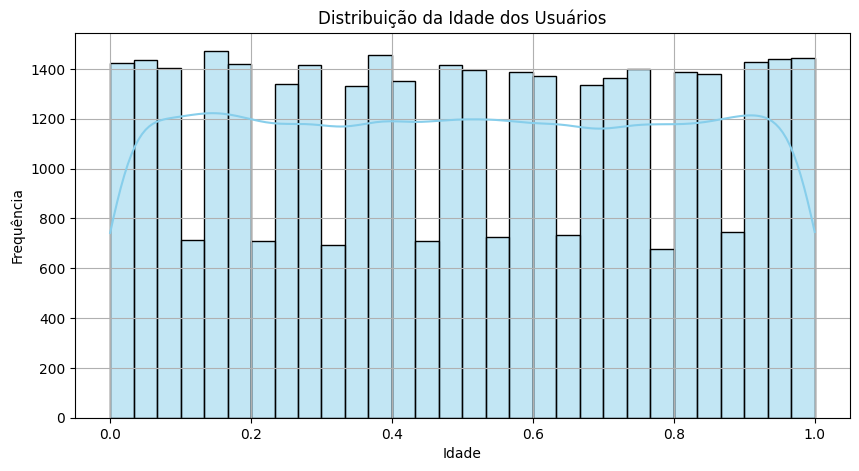

In [73]:
# Distribuição de Idade
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=30, kde=True, color="skyblue")
plt.title("Distribuição da Idade dos Usuários")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

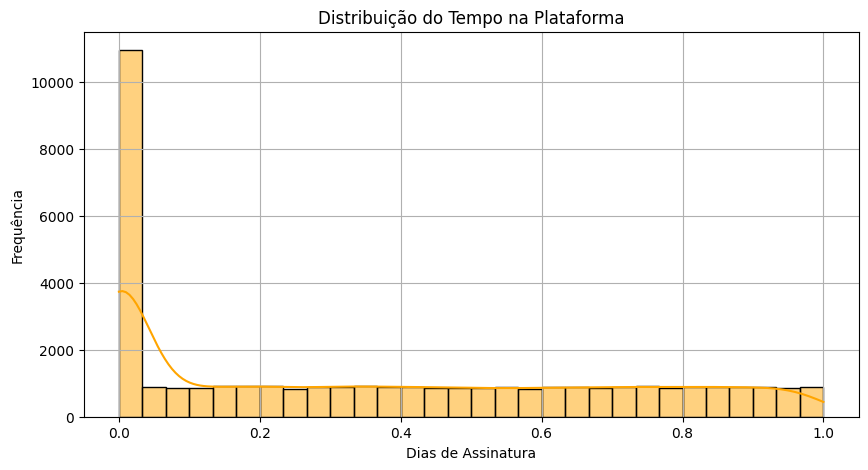

In [74]:
# Distribuição do tempo de uso na plataforma
plt.figure(figsize=(10, 5))
sns.histplot(df['Time_on_platform'], bins=30, kde=True, color="orange")
plt.title("Distribuição do Tempo na Plataforma")
plt.xlabel("Dias de Assinatura")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()


# **Etapa 2: Limpeza e Preparação dos Dados**

# Nesta etapa, realizamos a preparação dos dados para a modelagem.
Foram aplicadas as seguintes transformações:
1. Substituímos valores nulos por 0 em colunas numéricas com fillna().
2. Removemos linhas com valores ausentes em colunas essenciais usando dropna().
3. Trocamos os valores da coluna 'Churned' de 0 e 1 para 'No' e 'Yes' com replace().
4. Convertamos colunas de float para inteiro com astype(int).

Todas essas ações são essenciais para garantir a integridade dos dados e atender aos critérios mínimos exigidos para a modelagem.

In [75]:
# 1. Substituir NaN por 0
cols_fill_0 = ['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']
df[cols_fill_0] = df[cols_fill_0].fillna(0)

In [80]:
# 2. Remover linhas com NaN em colunas essenciais
required_cols = ['Gender', 'Subscription_type', 'Age']
existing_cols = [col for col in required_cols if col in df.columns]
df = df.dropna(subset=existing_cols)

In [77]:
# 3. Substituir valores da coluna Churned
df['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})

In [81]:
# 4. Converter colunas float em int
float_to_int_cols = ['Age', 'Time_on_platform', 'Devices_connected', 'Num_streaming_services', 'Avg_rating']
for col in float_to_int_cols:
    df[col] = df[col].astype(int)

In [86]:
# 5. Codificar variáveis categóricas
# Verifica se as colunas existem antes de aplicar get_dummies
cols_to_encode = ['Gender', 'Subscription_type']
existing_encode = [col for col in cols_to_encode if col in df.columns]
if existing_encode:
    df = pd.get_dummies(df, columns=existing_encode, drop_first=True)

In [84]:
# 6. Escalar variáveis numéricas
scaler = MinMaxScaler()
scaled_features = ['Age', 'Time_on_platform', 'Devices_connected', 'Num_streaming_services', 'Num_active_profiles', 'Avg_rating']
df[scaled_features] = scaler.fit_transform(df[scaled_features])

# **Etapa 3 – Modelagem com Regressão Logística**

### Nesta etapa, iniciamos a construção de um modelo de machine learning para prever o churn de usuários da plataforma.

### Essa etapa cumpre os requisitos de utilização de fit(), transform(), predict(),e traz uma baseline comparativa para os próximos modelos.

In [87]:
# Preparar dados
X = df.drop(columns=['Churned', 'User_id'])
y = LabelEncoder().fit_transform(df['Churned'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [88]:
# Treinar modelo
model_log = LogisticRegression(max_iter=1000)
model_log.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [25]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Relatório - Regressão Logística
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      8884
           1       0.00      0.00      0.00      2071

    accuracy                           0.81     10955
   macro avg       0.41      0.50      0.45     10955
weighted avg       0.66      0.81      0.73     10955



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


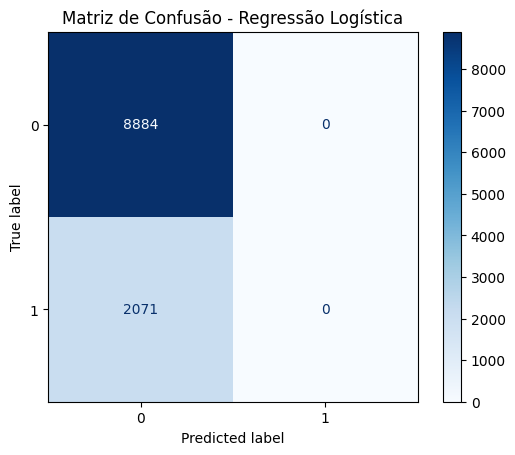

In [89]:
# Avaliação
y_pred_log = model_log.predict(X_test)
print("\nRelatório - Regressão Logística")
print(classification_report(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp_log.plot(cmap='Blues')
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()

# **Etapa 4 - Otimizacao e Novo Modelo**

In [90]:
# 1. LabelEncoder aplicado à variável alvo
le = LabelEncoder()
df['Churned_Label'] = le.fit_transform(df['Churned'])

In [94]:
# 2. train_test_split
X = df.drop(columns=['Churned', 'Churned_Label', 'User_id'])
y = df['Churned_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [95]:
# 3. fit()
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [96]:
# 4. predict()
y_pred = rf_model.predict(X_test)


In [97]:
# 5. assign()
resultado_df = pd.DataFrame(X_test.copy())
resultado_df = resultado_df.assign(Real=y_test, Previsto=y_pred)
print("\nAmostra com previsões:")
print(resultado_df.head())




Amostra com previsões:
       Age  Time_on_platform  Devices_connected  Num_streaming_services  \
25295  0.0               0.0                0.0                     0.0   
27047  0.0               0.0                0.0                     0.0   
74738  0.0               0.0                0.0                     0.0   
77654  0.0               0.0                0.0                     0.0   
40757  0.0               0.0                0.0                     0.0   

       Num_active_profiles  Avg_rating  Gender_Male  \
25295                 0.75         0.0         True   
27047                 0.75         0.0        False   
74738                 0.00         0.0        False   
77654                 0.25         0.0        False   
40757                 0.75         0.0        False   

       Subscription_type_Premium  Subscription_type_Standard  Real  Previsto  
25295                      False                       False     0         0  
27047                      False    

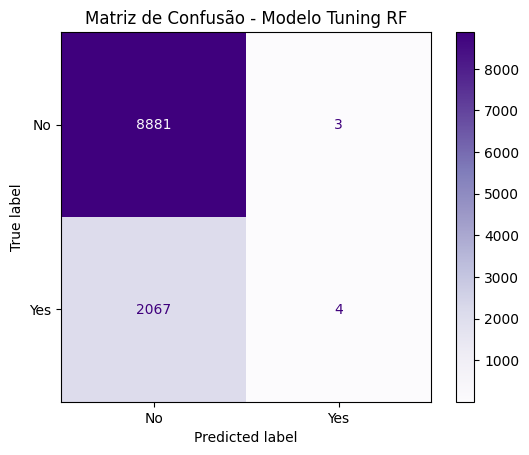

In [98]:
# 6. ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Purples')
plt.title("Matriz de Confusão - Modelo Tuning RF")
plt.show()

In [99]:
# Parâmetros do modelo
print("\nParâmetros do modelo Random Forest:")
print(rf_model.get_params())


Parâmetros do modelo Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


# **Etapa 5 - Modelagem Final com GridSearchCV - Random Forest**

In [100]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid,
                       scoring='f1',
                       cv=3,
                       n_jobs=-1)


In [101]:
# fit()
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [102]:
# get_params()
best_rf = grid_rf.best_estimator_
print("\nMelhores parâmetros do modelo final:")
print(best_rf.get_params())


Melhores parâmetros do modelo final:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [103]:
# predict()
y_pred_rf = best_rf.predict(X_test)

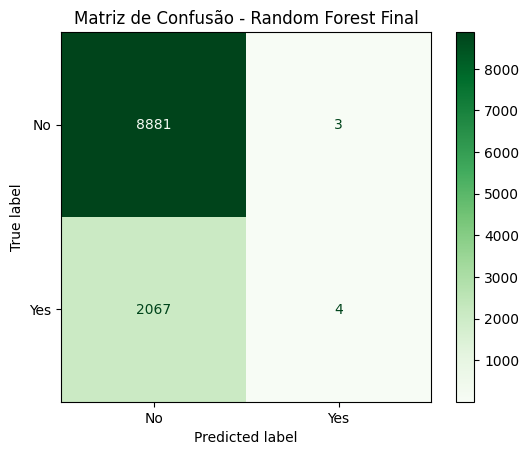

In [104]:
# ConfusionMatrixDisplay
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)
disp_rf.plot(cmap='Greens')
plt.title("Matriz de Confusão - Random Forest Final")
plt.show()

In [105]:
# classification_report
print("\nRelatório de Classificação - Random Forest Final")
print(classification_report(y_test, y_pred_rf))



Relatório de Classificação - Random Forest Final
              precision    recall  f1-score   support

           0       0.81      1.00      0.90      8884
           1       0.57      0.00      0.00      2071

    accuracy                           0.81     10955
   macro avg       0.69      0.50      0.45     10955
weighted avg       0.77      0.81      0.73     10955



# **Etapa 6 - Análise do Perfil com Maior Churn**

In [111]:
# Importância das variáveis para o modelo Random Forest
importances = best_rf.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

<ipython-input-112-8f8f5f112495>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


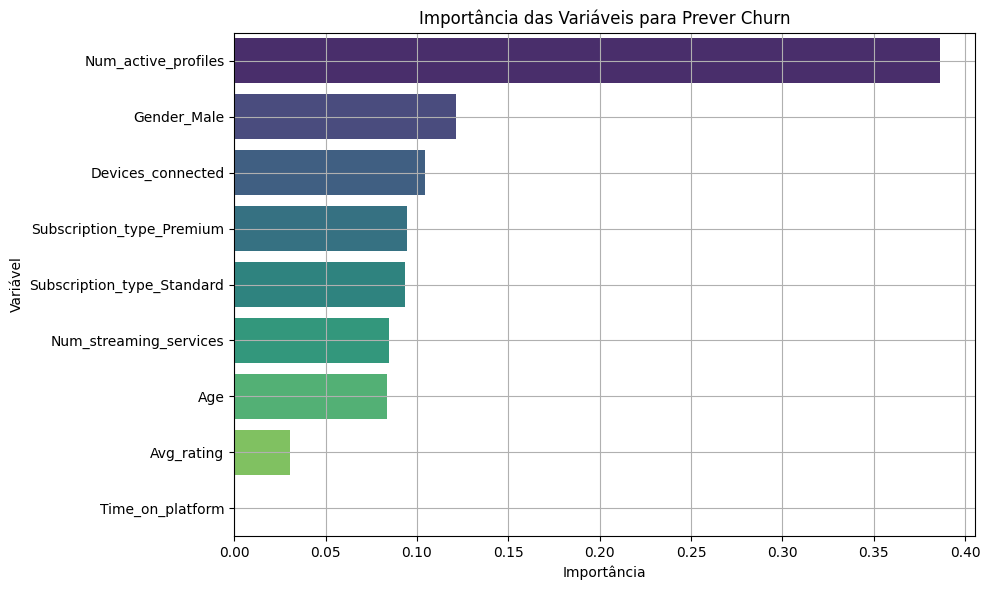

In [112]:
# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importância das Variáveis para Prever Churn')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
# Top 5 variáveis
print("Top 5 variáveis mais relevantes para prever churn:")
print(feature_importance_df.head())

Top 5 variáveis mais relevantes para prever churn:
                      Feature  Importance
4         Num_active_profiles    0.386104
6                 Gender_Male    0.121616
2           Devices_connected    0.104336
7   Subscription_type_Premium    0.094361
8  Subscription_type_Standard    0.093757


**Análise** – Perfil com Maior Propensão ao Churn
Com base na importância das variáveis geradas pelo modelo Random Forest, identificamos o seguinte perfil de usuários com maior chance de deixar a plataforma:

**Top 5 variáveis mais relevantes:**

Num_active_profiles – Quanto menos perfis ativos, maior a chance de churn.

Gender_Male – Usuários identificados como do sexo masculino têm maior probabilidade de cancelamento.

Devices_connected – Baixa conectividade de dispositivos está associada a maior churn.

Subscription_type_Premium – Curiosamente, até usuários com plano premium apresentam risco se outros fatores estiverem presentes.

Subscription_type_Standard – Usuários com plano padrão também estão no radar de risco.

**Conclusão Estratégica**
O modelo aponta que baixa interação com a plataforma (menos perfis e dispositivos) e tipos de assinatura específicos influenciam diretamente o risco de saída.

**Ações possíveis:**

Criar campanhas para incentivar criação de perfis adicionais.

Oferecer melhor onboarding para usuários do sexo masculino.

Avaliar experiência do cliente em planos Premium e Standard.